In [1]:
%load_ext autoreload

In [2]:
%autoreload
import torch
import torch.nn as nn
from collections import OrderedDict
from models.SceneNetStereoJointIter import SceneNetStereoJointIter
from datasets.kitti_2015_train import KITTI_2015_MonoSceneFlow_Full

from losses_eval import Eval_SceneFlow_KITTI_Test, Eval_SceneFlow_KITTI_Train
from losses import Loss_SceneFlow_SelfSup_Joint

from augmentations import Augmentation_Resize_Only
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint

class Args:
    model_name='scenenet_joint_stereo_iter'
    cuda = True
    use_bn = True
    momentum = 0.9
    beta = 0.999
    weight_decay=0.0
    use_mask = True
    sf_lr_w = 0.0
    pose_lr_w = 0.0
    mask_lr_w = 1.0
    disp_lr_w = 1.0
    disp_pts_w = 0.0
    sf_pts_w = 0.2
    sf_sm_w = 200
    pose_sm_w = 200
    pose_pts_w = 0.2
    disp_sm_w = 0.2
    disp_smooth_w = 0.1
    mask_reg_w = 0.2
    static_cons_w = 1.0
    mask_cons_w = 0.2
    mask_sm_w = 0.1
    flow_diff_thresh=1e-3
    evaluation=True

args = Args()

model = SceneNetStereoJointIter(args).cuda()
state_dict = torch.load('pretrained/scenenet_joint/latest.ckpt')['model']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

augmentation = Augmentation_Resize_Only(args).cuda()

val_dataset = KITTI_2015_MonoSceneFlow_Full(args, root="/external/datasets/kitti2015/")
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=1, pin_memory=False)

loss = Eval_SceneFlow_KITTI_Train(args)
train_loss = Loss_SceneFlow_SelfSup_Joint(args)

In [3]:
loss_dict_avg = {}

for i, data in enumerate(tqdm(val_loader)):
    with torch.no_grad():
        # Get input and target tensor keys
        input_keys = list(filter(lambda x: "input" in x, data.keys()))
        target_keys = list(filter(lambda x: "target" in x, data.keys()))
        tensor_keys = input_keys + target_keys
        
        # Possibly transfer to Cuda
        for k, v in data.items():
            if k in tensor_keys:
                data[k] = v.cuda(non_blocking=True)
                
        aug_data = augmentation(data)
        out = model(aug_data)
        train_loss_dict = train_loss(out, data)
        pprint(train_loss_dict)
        loss_dict = loss(out, data)
        
        if i == 1:
            break
        
        for k, v in loss_dict.items():
            if k not in loss_dict_avg:
                loss_dict_avg[k] = v
            else:
                loss_dict_avg[k] += v

# pct_keys = ['d1', 'f1', 'd2', 'sf']
# for k, v in loss_dict_avg.items():
#     loss_dict_avg[k] = v / 200;
#     if k in pct_keys:
#         loss_dict_avg[k] = v * 100;

  0%|          | 1/200 [00:01<05:44,  1.73s/it]

{'disp': tensor(2.7636, device='cuda:0'),
 'disp_im': tensor(1.5514, device='cuda:0'),
 'disp_lr': tensor(0.0445, device='cuda:0'),
 'disp_pts': tensor(2.7378, device='cuda:0'),
 'mask': tensor(2.0690, device='cuda:0'),
 'mask_consensus': tensor(11.9975, device='cuda:0'),
 'mask_lr': tensor(0.1026, device='cuda:0'),
 'mask_reg': tensor(5.0593, device='cuda:0'),
 'mask_smooth': tensor(0.0416, device='cuda:0'),
 'pose': tensor(2.2605, device='cuda:0'),
 'pose_im': tensor(1.2345, device='cuda:0'),
 'pose_pts': tensor(0.2166, device='cuda:0'),
 'pose_smooth': tensor(1.1325e-05, device='cuda:0'),
 's_2': tensor(1.6000, device='cuda:0'),
 's_3': tensor(0.5014, device='cuda:0'),
 's_3s': tensor(0.0001, device='cuda:0'),
 'sf': tensor(2.8348, device='cuda:0'),
 'static_cons': tensor(41.2506, device='cuda:0'),
 'total_loss': tensor(56.9660, device='cuda:0')}


  0%|          | 1/200 [00:03<10:46,  3.25s/it]

{'disp': tensor(1.3271, device='cuda:0'),
 'disp_im': tensor(0.7588, device='cuda:0'),
 'disp_lr': tensor(0.0201, device='cuda:0'),
 'disp_pts': tensor(2.5899, device='cuda:0'),
 'mask': tensor(2.0673, device='cuda:0'),
 'mask_consensus': tensor(11.5379, device='cuda:0'),
 'mask_lr': tensor(0.1065, device='cuda:0'),
 'mask_reg': tensor(5.2025, device='cuda:0'),
 'mask_smooth': tensor(0.0381, device='cuda:0'),
 'pose': tensor(1.7805, device='cuda:0'),
 'pose_im': tensor(0.9971, device='cuda:0'),
 'pose_pts': tensor(0.2260, device='cuda:0'),
 'pose_smooth': tensor(2.3307e-05, device='cuda:0'),
 's_2': tensor(1.5153, device='cuda:0'),
 's_3': tensor(0.5039, device='cuda:0'),
 's_3s': tensor(0.0001, device='cuda:0'),
 'sf': tensor(2.7324, device='cuda:0'),
 'static_cons': tensor(87.0846, device='cuda:0'),
 'total_loss': tensor(103.8725, device='cuda:0')}


In [4]:
from utils.inverse_warp import pose2flow
from utils.sceneflow_util import projectSceneFlow2Flow
from losses import _elementwise_epe, static_cons_loss
from utils.sceneflow_util import pts2pixel_ms, pts2pixel_pose_ms, pixel2pts_ms_depth, reconstructImg

k_l2_aug = data['input_k_l2_aug'].detach()
aug_size = data['aug_size']

flow = out['flow_b'][0].detach()
pose = out['pose_b'][0].detach()
disp_l2 = out['disp_l2'][0].detach()
mask_l2 = out['mask_l2'][0].detach()

# disparity
disp_l2 = out['disp_l2'][0].detach()
_, _, h_dp, w_dp = flow.size()
disp_l2 = disp_l2 * w_dp

local_scale = torch.zeros_like(aug_size)
local_scale[:, 0] = h_dp
local_scale[:, 1] = w_dp

pts2, k2_scale, depth = pixel2pts_ms_depth(
    k_l2_aug, disp_l2, local_scale / aug_size)

x = pose2flow(depth.squeeze(dim=1), None, k2_scale, torch.inverse(k2_scale), pose_mat=pose)
y = projectSceneFlow2Flow(k2_scale, flow, disp_l2)
diff = _elementwise_epe(x, y).mean(dim=1)
(diff * mask_l2).mean()

tensor(5.8402, device='cuda:0')

In [5]:
def get_visuals(input_dict, output_dict, model_name='scenenet_joint'):

    img_l1_aug = input_dict['input_l1_aug'].detach()
    img_l2_aug = input_dict['input_l2_aug'].detach()
    img_r2_aug = input_dict['input_r2_aug'].detach()
    k_l2_aug = input_dict['input_k_l2_aug'].detach()
    aug_size = input_dict['aug_size']

    sf_b = output_dict['flow_b'][0].detach()
    if model_name == 'scenenet_stereo':
        pose = output_dict['pose_b'].detach()
    else:
        pose = output_dict['pose_b'][0].detach()

    mask = output_dict['mask_l2'][0].detach()
    census_mask = output_dict['census_masks_l2'][0].detach()

    # disparity
    disp_l2 = output_dict['disp_l2'][0].detach()
    _, _, h_dp, w_dp = sf_b.size()
    disp_l2 = disp_l2 * w_dp

    # scene flow
    local_scale = torch.zeros_like(aug_size)
    local_scale[:, 0] = h_dp
    local_scale[:, 1] = w_dp

    pts2, k2_scale, depth = pixel2pts_ms_depth(
        k_l2_aug, disp_l2, local_scale / aug_size)

    _, _, coord2 = pts2pixel_ms(k2_scale, pts2, sf_b, [h_dp, w_dp])
    img_l1_warp = reconstructImg(coord2, img_l1_aug)

    # camera pose
    if 'joint' in args.model_name:
        _, coord2 = pts2pixel_pose_ms(k2_scale, pts2, None, [h_dp, w_dp], pose_mat=pose)
    else:
        _, coord2 = pts2pixel_pose_ms(k2_scale, pts2, pose, [h_dp, w_dp])
        
    img_l1_warp_cam = reconstructImg(coord2, img_l1_aug)
    
    disp_l2 = disp_l2.cpu().squeeze()
    img_l1_warp = img_l1_warp.cpu().squeeze().permute(1, 2, 0)
    img_l1_warp_cam = img_l1_warp_cam.cpu().squeeze().permute(1, 2, 0)
    mask = mask.cpu().squeeze()
    census_mask = census_mask.cpu().squeeze()
    
    return disp_l2, img_l1_warp, img_l1_warp_cam, mask, census_mask

disp_l2, img_l1_warp, img_l1_warp_cam, mask, census_mask = get_visuals(data, out)

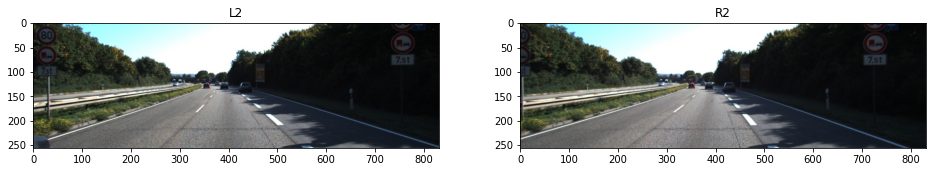

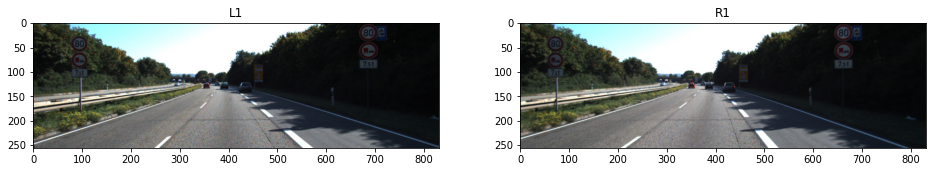

In [6]:
img_l1 = data['input_l1_aug'].squeeze().permute(1, 2, 0).cpu()
img_l2 = data['input_l2_aug'].squeeze().permute(1, 2, 0).cpu()
img_r1 = data['input_r1_aug'].squeeze().permute(1, 2, 0).cpu()
img_r2 = data['input_r2_aug'].squeeze().permute(1, 2, 0).cpu()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 16))
ax1.imshow(img_l2)
ax1.title.set_text('L2')
ax2.imshow(img_r2)
ax2.title.set_text('R2')

fig, (ax3, ax4) = plt.subplots(1,2, figsize=(16, 16))
ax3.imshow(img_l1)
ax3.title.set_text('L1')
ax4.imshow(img_r1)
ax4.title.set_text('R1')

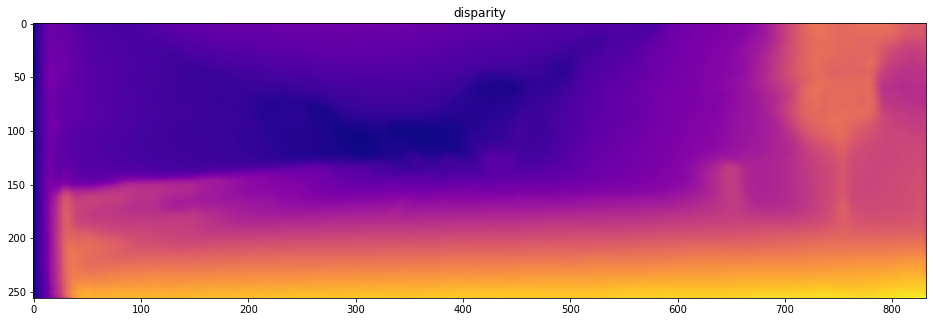

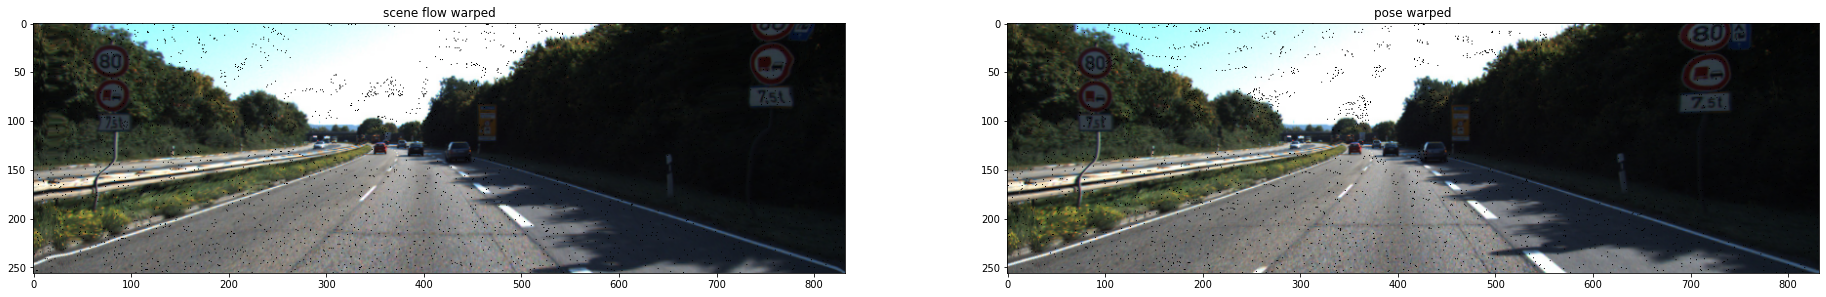

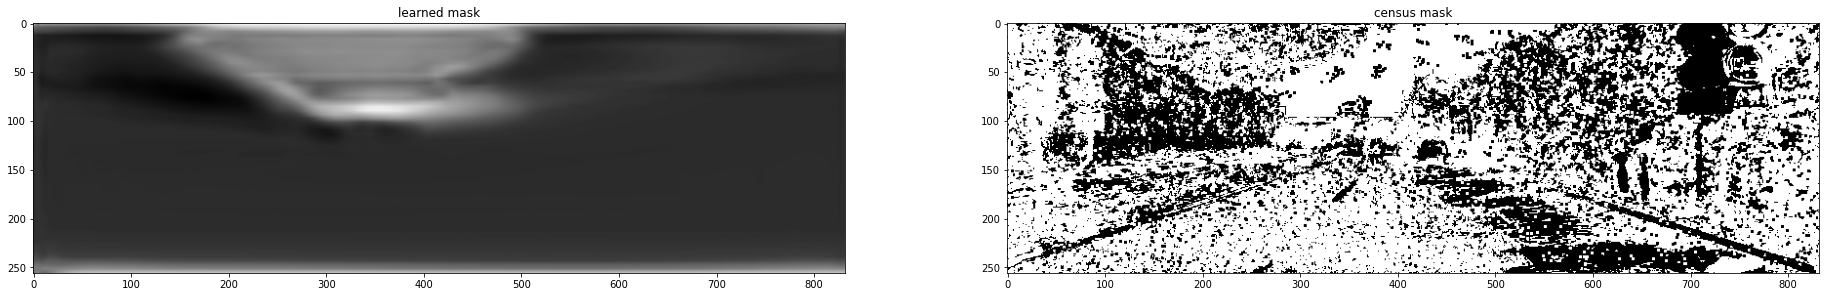

In [7]:
plt.figure(figsize=(16, 16))
plt.imshow(disp_l2, cmap='plasma')
plt.title('disparity')
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(32, 32));
ax1.imshow(img_l1_warp);
ax1.title.set_text('scene flow warped')
ax2.imshow(img_l1_warp_cam);
ax2.title.set_text('pose warped')

fig, (ax3, ax4) = plt.subplots(1,2, figsize=(32, 32));
ax3.imshow(mask, cmap='gray');
ax3.title.set_text('learned mask')
ax4.imshow(census_mask, cmap='gray');
ax4.title.set_text('census mask')